![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)
data = data.reset_index(drop=True)
# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
0,21995,2014,6480,False,False,False,True,False,False,False
1,13995,2014,39972,False,False,False,False,True,False,False
2,17941,2016,18989,False,False,False,False,False,True,False
3,12493,2014,51330,False,False,False,True,False,False,False
4,7994,2007,116065,False,True,False,False,False,False,False


In [37]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)
X.head(10)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
0,2014,6480,False,False,False,True,False,False,False
1,2014,39972,False,False,False,False,True,False,False
2,2016,18989,False,False,False,False,False,True,False
3,2014,51330,False,False,False,True,False,False,False
4,2007,116065,False,True,False,False,False,False,False
5,2017,21255,False,False,False,False,False,True,False
6,2011,220227,False,True,False,False,False,False,False
7,2016,43061,False,False,False,False,False,True,False
8,2015,47820,False,False,False,False,False,False,True
9,2015,55046,False,False,False,False,True,False,False


In [38]:
columnas_categoricas = X.iloc[:, 2:].columns
valores_unicos = {columna: X[columna].unique() for columna in columnas_categoricas}

print(valores_unicos)

{'M_Camry': array([False,  True]), 'M_Camry4dr': array([False,  True]), 'M_CamryBase': array([False,  True]), 'M_CamryL': array([ True, False]), 'M_CamryLE': array([False,  True]), 'M_CamrySE': array([False,  True]), 'M_CamryXLE': array([False,  True])}


In [39]:
X[columnas_categoricas] = X[columnas_categoricas].astype(int)
X.head(10)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
0,2014,6480,0,0,0,1,0,0,0
1,2014,39972,0,0,0,0,1,0,0
2,2016,18989,0,0,0,0,0,1,0
3,2014,51330,0,0,0,1,0,0,0
4,2007,116065,0,1,0,0,0,0,0
5,2017,21255,0,0,0,0,0,1,0
6,2011,220227,0,1,0,0,0,0,0
7,2016,43061,0,0,0,0,0,1,0
8,2015,47820,0,0,0,0,0,0,1
9,2015,55046,0,0,0,0,1,0,0


In [40]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [41]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [42]:
import numpy as np


def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain

    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=5):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree

    j, split, gain = best_split(X, y, num_pct)
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   

    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])
    print(X.shape[0])
    print(predicted)

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejemplo de uso con datos y objetivo
tree = tree_grow(X_train, y_train, level=2, min_gain=0.001, max_depth=4, num_pct=200)
tree

{'y_pred': 1,
 'y_prob': 14503.947817432107,
 'level': 2,
 'split': [0, 2013.0],
 'n_samples': 7031,
 'gain': 17580092.346093953,
 'sl': {'y_pred': 1,
  'y_prob': 9751.165063291139,
  'level': 3,
  'split': [0, 2012.0],
  'n_samples': 1973,
  'gain': 5918931.7034190595,
  'sl': {'y_pred': 1,
   'y_prob': 8725.304318026045,
   'level': 4,
   'split': -1,
   'n_samples': 1457,
   'gain': 2326660.1337252855},
  'sr': {'y_pred': 1,
   'y_prob': 12602.95945945946,
   'level': 4,
   'split': -1,
   'n_samples': 516,
   'gain': 2727452.981269896}},
 'sr': {'y_pred': 1,
  'y_prob': 16353.303359683794,
  'level': 3,
  'split': [0, 2017.0],
  'n_samples': 5058,
  'gain': 3241195.292231798,
  'sl': {'y_pred': 1,
   'y_prob': 15786.223195266271,
   'level': 4,
   'split': -1,
   'n_samples': 4223,
   'gain': 1804558.347450912},
  'sr': {'y_pred': 1,
   'y_prob': 19176.729988052568,
   'level': 4,
   'split': -1,
   'n_samples': 835,
   'gain': 2187265.7136490345}}}

In [43]:
predicciones_arbol_manual = tree_predict(X_test, tree)

3464
[1. 1. 1. ... 1. 1. 1.]
941
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [10]:
# Celda 2


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [44]:
# Celda 3
n_estimators = 10
max_features = int(np.log2(X_train.shape[1])) 
bagreg = BaggingRegressor(
    DecisionTreeRegressor(max_features=max_features),
    n_estimators=n_estimators,
    bootstrap=True,
    oob_score=True,
    random_state=1
)
baggin_libreria = bagreg.fit(X_train, y_train)
baggin_libreria

BaggingRegressor(estimator=DecisionTreeRegressor(max_features=3),
                 oob_score=True, random_state=1)

In [48]:
predic_baggin = baggin_libreria.predict(X_test)
mse_baggin = mean_squared_error(y_test, predic_baggin)
mse_baggin

3329530.115417581

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [47]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)


RandomForestRegressor()

In [49]:
predicciones_rfr = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, predicciones_rfr)
mse_rfr

3101501.914216117

In [58]:
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mae = []
print(y)
# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    print(estimator)
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    scores = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_absolute_error')
    mae.append(scores.mean())
    print(scores)

0        21995
1        13995
2        17941
3        12493
4         7994
         ...  
10490    20825
10491    12995
10492     8812
10493    11595
10494    13995
Name: Price, Length: 10495, dtype: int64
10
[-1320.76069001 -1317.51378627 -1312.83249972 -1319.57149932
 -1347.12390641]
20
[-1310.38496189 -1307.7477618  -1302.08647825 -1310.7919984
 -1335.35494244]
30
[-1298.30136267 -1301.26632244 -1302.46320481 -1312.09534102
 -1327.14974478]
40
[-1298.42647848 -1297.90312915 -1301.06088582 -1308.18118593
 -1325.57226361]
50
[-1301.03159108 -1297.26865228 -1300.7509907  -1306.08797644
 -1323.79356388]
60
[-1302.39699341 -1290.65892402 -1299.40719468 -1304.84686383
 -1321.53891693]
70
[-1302.50184064 -1289.87010894 -1298.81532597 -1305.646133
 -1319.49770101]
80
[-1301.9842542  -1290.16773671 -1299.79880543 -1306.1198441
 -1320.26245417]
90
[-1300.84228176 -1290.4059193  -1299.43178457 -1309.00645806
 -1320.04151489]
100
[-1301.30631879 -1290.75238478 -1298.73751052 -1309.16127931
 -13

[-1323.5604763444699, -1313.273228556923, -1308.2551951429718, -1306.2287885998921, -1305.786554875467, -1303.7697785725736, -1303.2662219146055, -1303.6666189199016, -1303.9455917178066, -1303.7898491664603, -1303.1435164989125, -1303.2394368889827, -1303.1981170291922, -1302.8321130500867, -1302.7903675706802, -1302.8463372585034, -1302.7975674694776, -1302.9052521347792, -1302.7137171374966, -1302.5174679880108, -1302.751940829749, -1302.7643265411305, -1302.6416271046378, -1302.4674499575976, -1302.2536169906045, -1302.1744897805322, -1302.2557335557776, -1302.057407235498, -1302.1174236187921, -1302.0704435012562]


Text(0, 0.5, 'mae')

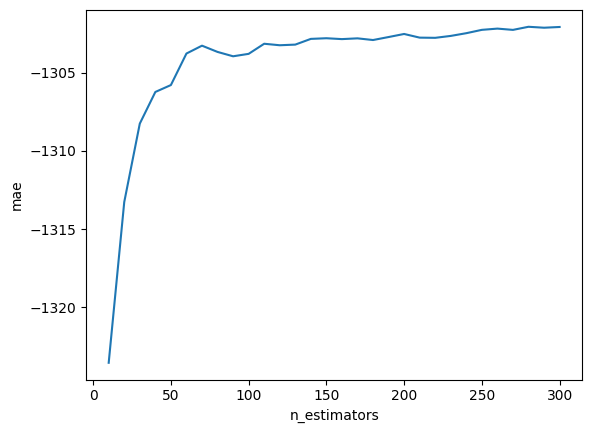

In [59]:
print(mae)
plt.plot(estimator_range, mae)
plt.xlabel('n_estimators')
plt.ylabel('mae')

In [60]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
print(X.shape[1])

feature_range = range(1, X.shape[1])

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores_feature = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    print(feature)
    clf = RandomForestRegressor(n_estimators=100, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores_feature.append(cross_val_score(clf, X, y, cv=5, scoring='neg_mean_absolute_error').mean())

9
1
2
3
4
5
6
7
8


Text(0, 0.5, 'mae')

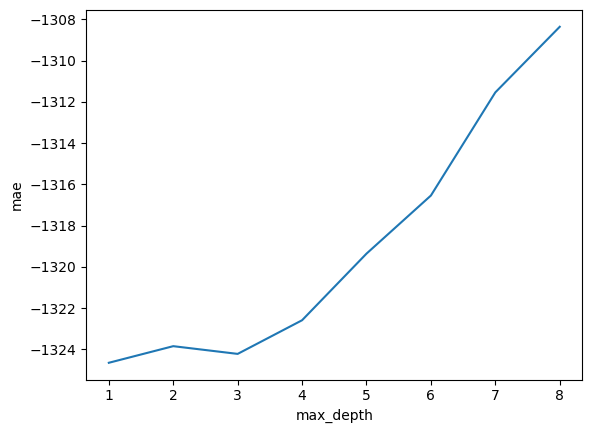

In [61]:
plt.plot(feature_range, accuracy_scores_feature)
plt.xlabel('max_depth')
plt.ylabel('mae')

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [81]:
# Celda 5
rfr = RandomForestRegressor(n_estimators=60,max_features=8)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_features=8, n_estimators=60)

In [82]:
predicciones_rfr = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, predicciones_rfr)
mse_rfr
#3101501

3128299.405981557

Si bien el modelo calibrado tiene un menor desempeño que el modelo que no esta calibrado es un mejor modelo ya que es un modelo mas sencillo que el modelo calibrado. ya que tiene un menor numero de estimadores ya que por defecto se trabaja con 100 estimadores.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
